In [13]:
# Libraries
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import quantus
from typing import Union

In [14]:
def choose_device() -> str:
    if torch.cuda.is_available():
        return "cuda:0"
    if hasattr(torch.backends, "mps"):
        if torch.backends.mps.is_available():
            return "mps"
    return "cpu"


device = torch.device(choose_device())
device

device(type='cuda', index=0)

In [15]:
PATH = "./ImageNet_subsample"

# Load test data and make loaders.
x_batch = torch.load(f'{PATH}/x_batch.pt')
y_batch = torch.load(f'{PATH}/y_batch.pt')
s_batch = torch.load(f'{PATH}/s_batch.pt')
x_batch, s_batch, y_batch = x_batch.to(device), s_batch.to(device), y_batch.to(device)
print(f"{len(x_batch)} matches found.")

17 matches found.


C:\Users\JALAL\AppData\Local\Temp\ipykernel_78172\4075827998.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x_batch = torch.load(f'{PATH}/x_batch.pt')
C:\Users\JALAL\Ap

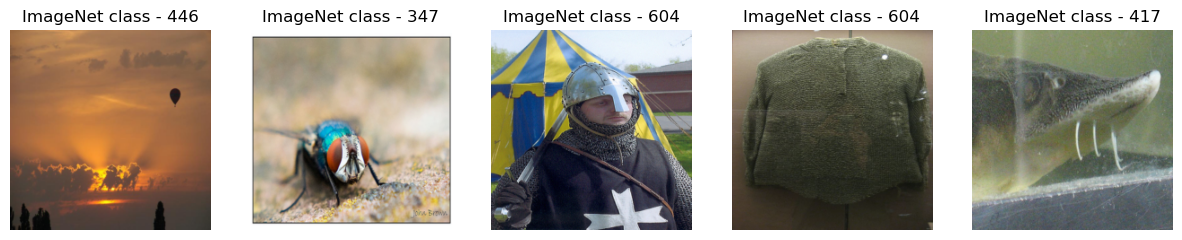

In [16]:
def normalize_image(arr: Union[np.ndarray, torch.Tensor]) -> np.ndarray:
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    if isinstance(arr, torch.Tensor):
        arr_copy = arr.clone().cpu().numpy()
    else:
        arr_copy = arr.copy()

    arr_copy = quantus.normalise_func.denormalise(arr_copy, mean=mean, std=std)
    arr_copy  = np.moveaxis(arr_copy, 0, -1)
    arr_copy = (arr_copy * 255.).astype(np.uint8)
    return arr_copy

# Plot some inputs!
nr_images = 5
fig, axes = plt.subplots(nrows=1, ncols=nr_images, figsize=(nr_images*3, int(nr_images*2/3)))
for i in range(nr_images):
    axes[i].imshow(normalize_image(x_batch[i]), vmin=0.0, vmax=1.0, cmap="gray")
    axes[i].title.set_text(f"ImageNet class - {y_batch[i].item()}")
    axes[i].axis("off")
plt.show()

In [17]:
# Load pre-trained ResNet18 model.
model = torchvision.models.resnet18(pretrained=True)
model = model.to(device)

## Quantus Explanations

In [18]:
# Generate Integrated Gradients attributions of the first batch of the test set.
a_batch = quantus.explain(model, x_batch, y_batch, method="IntegratedGradients")

# Save x_batch and y_batch as numpy arrays that will be used to call metric instances.
x_batch, s_batch, y_batch = x_batch.cpu().numpy(), s_batch.cpu().numpy(), y_batch.cpu().numpy()

# Make sure s_batch is of correct shape.
s_batch = s_batch.reshape(len(x_batch), 1, 224, 224)

# Quick assert.
assert [isinstance(obj, np.ndarray) for obj in [x_batch, y_batch, s_batch, a_batch]]

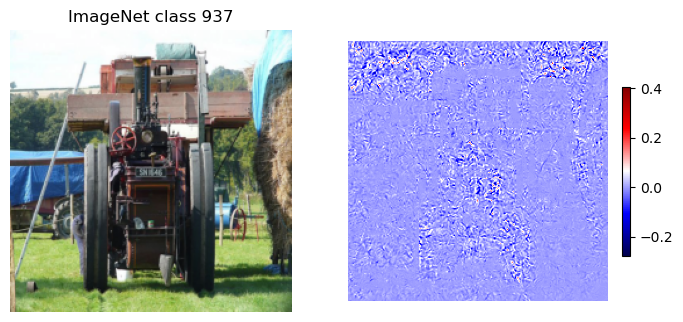

In [20]:
index = random.randint(0, len(x_batch)-1)

# Plot examplary explanations!
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
axes[0].imshow(normalize_image(x_batch[index]), vmin=0.0, vmax=1.0)
axes[0].title.set_text(f"ImageNet class {y_batch[index].item()}")
exp = axes[1].imshow(a_batch[index].reshape(224, 224), cmap="seismic")
fig.colorbar(exp, fraction=0.03, pad=0.05)
axes[0].axis("off")
axes[1].axis("off")
plt.show()

In [21]:
# Let's view what metrics categories are available.
quantus.helpers.constants.available_categories()

['Faithfulness',
 'Robustness',
 'Localisation',
 'Complexity',
 'Randomisation',
 'Axiomatic']

In [22]:
# In each category, let's view the available metrics.
quantus.helpers.constants.available_metrics()

{'Faithfulness': ['Faithfulness Correlation',
  'Faithfulness Estimate',
  'Pixel-Flipping',
  'Region Segmentation',
  'Monotonicity-Arya',
  'Monotonicity-Nguyen',
  'Selectivity',
  'SensitivityN',
  'IROF',
  'ROAD',
  'Infidelity',
  'Sufficiency'],
 'Robustness': ['Continuity Test',
  'Local Lipschitz Estimate',
  'Max-Sensitivity',
  'Avg-Sensitivity',
  'Consistency',
  'Relative Input Stability',
  'Relative Output Stability',
  'Relative Representation Stability'],
 'Localisation': ['Pointing Game',
  'Top-K Intersection',
  'Relevance Mass Accuracy',
  'Relevance Rank Accuracy',
  'Attribution Localisation ',
  'AUC',
  'Focus'],
 'Complexity': ['Sparseness', 'Complexity', 'Effective Complexity'],
 'Randomisation': ['MPRT', 'Smooth MPRT', 'Efficient MPRT', 'Random Logit'],
 'Axiomatic': ['Completeness', 'NonSensitivity', 'InputInvariance']}

In [23]:
quantus.FaithfulnessCorrelation(
    nr_runs=100,  
    subset_size=224,  
    perturb_baseline="black",
    perturb_func=quantus.perturb_func.baseline_replacement_by_indices,
    similarity_func=quantus.similarity_func.correlation_pearson,  
    abs=False,  
    return_aggregate=False,
)(model=model, 
   x_batch=x_batch, 
   y_batch=y_batch,
   a_batch=a_batch,
   device=device)

[0.08113805155871076,
 0.06410932563205349,
 -0.3414393688387927,
 -0.18211718584445527,
 -0.004481949581227338,
 -0.009075334309619995,
 -0.30327148830721445,
 -0.0726125995830513,
 0.08353969972059111,
 0.011722613198606794,
 -0.09592993143347096,
 0.08532136692962843,
 -0.09245145329773376,
 -0.07319873795362158,
 0.01500730566642272,
 -0.091424157543732,
 -0.2186237859918323]